In [2]:
import torch
import os
from model_hyperbolic import GPTConfig, GPT

checkpoint_path = os.path.join('/raid/out-tinystories', 'ckpt_hyperbolic.pt')
# Load the checkpoint
checkpoint = torch.load(checkpoint_path, map_location='cpu')

# Load the model arguments from the checkpoint
model_args = checkpoint['model_args']

# Initialize the model with the loaded config
gpt_config = GPTConfig(**model_args)
model = GPT(gpt_config)

# Load the model state dictionary
state_dict = checkpoint['model']

# Remove unwanted prefix if present
unwanted_prefix = '_orig_mod.'
for k in list(state_dict.keys()):
    if k.startswith(unwanted_prefix):
        state_dict[k[len(unwanted_prefix):]] = state_dict.pop(k)

# Load state dict into the model
model.load_state_dict(state_dict)

number of parameters: 4.37M


<All keys matched successfully>

In [3]:
model.transformer.h

ModuleList(
  (0-11): 12 x Block(
    (ln_1): LayerNorm()
    (attn): CausalSelfAttention(
      (c_attn): Linear(in_features=72, out_features=216, bias=False)
      (c_proj): Linear(in_features=72, out_features=72, bias=False)
      (attn_dropout): Dropout(p=0.2, inplace=False)
      (resid_dropout): Dropout(p=0.2, inplace=False)
    )
    (ln_2): LayerNorm()
    (mlp): MLP(
      (c_fc): Linear(in_features=72, out_features=288, bias=False)
      (gelu): GELU(approximate='none')
      (c_proj): Linear(in_features=288, out_features=72, bias=False)
      (dropout): Dropout(p=0.2, inplace=False)
    )
  )
)

In [14]:
# Iterate through the layers and print the value of the 'c' parameter in hyperbolic mode
for i, block in enumerate(model.transformer.h):
    # if isinstance(block.attn, CausalSelfAttention) and block.attn.mode == 'hyperbolic':
    # print(f"Layer {i}: c = {block.attn.c.item():.3f}")
    qkv = block.attn.c_attn.weight
    q, k, v = qkv.split(72)
    break

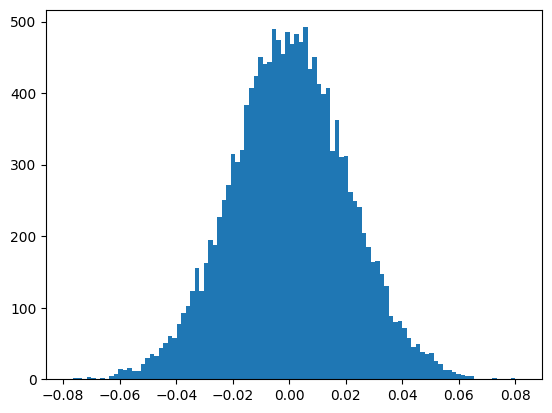

In [20]:
import matplotlib.pyplot as plt
plt.hist(qkv.flatten().detach().numpy(), bins=100)
plt.show()

In [9]:
for i, block in enumerate(model.transformer.h):
    for name, param in block.named_parameters():
        print(f"Name: {name} | Shape: {param.shape} | Requires Grad: {param.requires_grad}")
    break

Name: ln_1.weight | Shape: torch.Size([72]) | Requires Grad: True
Name: attn.c | Shape: torch.Size([]) | Requires Grad: True
Name: attn.c_attn.weight | Shape: torch.Size([216, 72]) | Requires Grad: True
Name: attn.c_proj.weight | Shape: torch.Size([72, 72]) | Requires Grad: True
Name: ln_2.weight | Shape: torch.Size([72]) | Requires Grad: True
Name: mlp.c_fc.weight | Shape: torch.Size([288, 72]) | Requires Grad: True
Name: mlp.c_proj.weight | Shape: torch.Size([72, 288]) | Requires Grad: True


In [29]:
import os
from tensorboard.backend.event_processing import event_accumulator
import matplotlib.pyplot as plt

# Define the path to your root logs directory
root_log_dir = "/raid/runs"  # Adjust this path if necessary

# Get a list of all experiment folders
log_dirs = [os.path.join(root_log_dir, d) for d in os.listdir(root_log_dir)]

log_dirs

['/raid/runs/10.02',
 '/raid/runs/lorentz_mode_hyperbolic_curvature_1.0_n_layer_12_n_head_12_n_embd_72_learning_rate_0.0003_min_lr_3e-05_lr_decay_iters_40000_batch_size_1_gradient_accumulation_steps_1_10.02-16.47',
 '/raid/runs/lorentz_mode_hyperbolic_curvature_1.0_n_layer_12_n_head_12_n_embd_72_learning_rate_0.0003_min_lr_3e-05_lr_decay_iters_40000_batch_size_1_gradient_accumulation_steps_2_10.02-17.19',
 '/raid/runs/n_layer_12_n_head_12_n_embd_72_block_size_1024_bias_False_vocab_size_50304_dropout_0.2_mode_original',
 '/raid/runs/lorentz_mode_hyperbolic_curvature_learn_exp_n_layer_12_n_head_12_n_embd_72_learning_rate_0.0003_min_lr_3e-05_lr_decay_iters_40000_batch_size_1_gradient_accumulation_steps_2_10.02-18.12',
 '/raid/runs/lorentz_mode_hyperbolic_curvature_learn_exp_n_layer_12_n_head_12_n_embd_72_learning_rate_0.0003_min_lr_3e-05_lr_decay_iters_40000_batch_size_1_gradient_accumulation_steps_2_10.02-18.20']

In [30]:
log_dirs_bs1 = [log_dirs[0], log_dirs[2]]
log_dirs_bs2 = [log_dirs[1], log_dirs[2]]
log_dirs_o = log_dirs[:4]
log_dirs_l = log_dirs[4:]

In [22]:
log_dirs

['/raid/runs/lorentz_mode_hyperbolic_curvature_1.0_n_layer_12_n_head_12_n_embd_72_learning_rate_0.0003_min_lr_3e-05_lr_decay_iters_40000_batch_size_1_gradient_accumulation_steps_2_10.02-17.19',
 '/raid/runs/n_layer_12_n_head_12_n_embd_72_block_size_1024_bias_False_vocab_size_50304_dropout_0.2_mode_original',
 '/raid/runs/lorentz_mode_hyperbolic_curvature_learn_exp_n_layer_12_n_head_12_n_embd_72_learning_rate_0.0003_min_lr_3e-05_lr_decay_iters_40000_batch_size_1_gradient_accumulation_steps_2_10.02-18.12',
 '/raid/runs/lorentz_mode_hyperbolic_curvature_learn_exp_n_layer_12_n_head_12_n_embd_72_learning_rate_0.0003_min_lr_3e-05_lr_decay_iters_40000_batch_size_1_gradient_accumulation_steps_2_10.02-18.20']

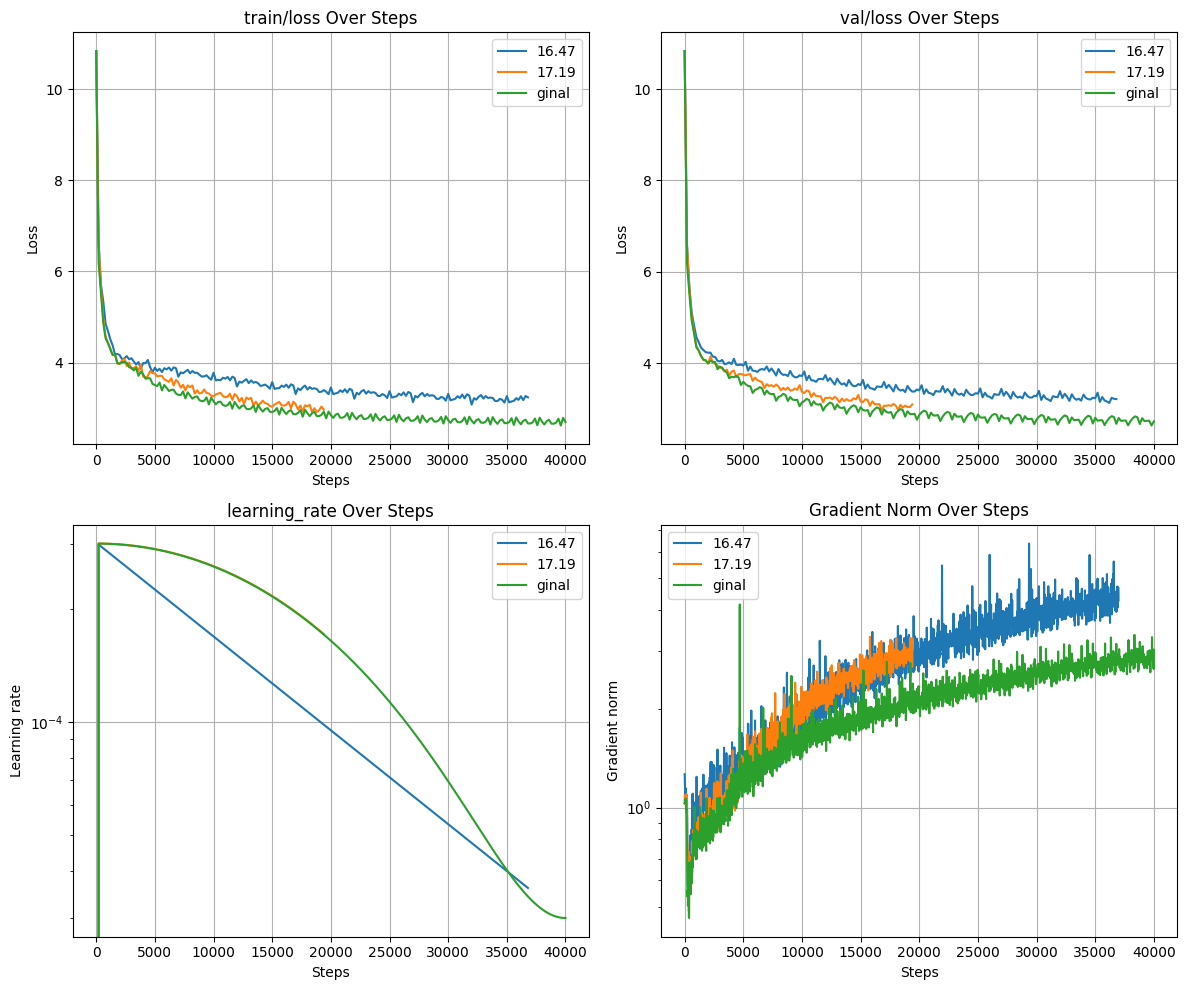

In [32]:
logs_to_show=log_dirs_o
exp_names = [n[-5:] for n in logs_to_show]

# Initialize a dictionary to hold data for each experiment
experiment_data = {}

for log_dir in logs_to_show:
    # Load TensorBoard logs
    event_acc = event_accumulator.EventAccumulator(log_dir)
    event_acc.Reload()
    
    # Get available scalar tags (train/loss, val/loss, learning_rate, Gradient Norm)
    tags = ['train/loss', 'val/loss', 'learning_rate', 'Gradient Norm']
    
    # Extract and store scalar values for each tag
    data = {}
    for tag in tags:
        if tag in event_acc.Tags().get('scalars', []):  # Check if tag is available
            scalars = event_acc.Scalars(tag)
            steps = [s.step for s in scalars]
            values = [s.value for s in scalars]
            data[tag] = {'steps': steps, 'values': values}
    
    # Store the extracted data for this experiment folder
    experiment_data[os.path.basename(log_dir)] = data


metrics = ['train/loss', 'val/loss', 'learning_rate', 'Gradient Norm']

# exp_names = ['hyperbolic c=1e-5', 'original']

fig, axs = plt.subplots(2, 2, figsize=(12, 10))  # Create a 2x2 grid

# Flatten the axs array for easy iteration
axs = axs.ravel()

# Loop over each metric and create a plot
for i, metric in enumerate(metrics):
    ax = axs[i]
    
    for (experiment, data), e in zip(experiment_data.items(), exp_names):
        if metric in data:
            steps = data[metric]['steps']
            values = data[metric]['values']
            ax.plot(steps, values, label=e)
    
    if not 'loss' in metric:
        ax.set_yscale('log')  # Set y-axis to logarithmic scale
    ax.set_xlabel('Steps')
    # ax.set_xlim([0, 1.1*max(steps)])
    ax.set_ylabel(metric.split('/')[-1].replace('_', ' ').capitalize())  # Clean y-axis label
    ax.set_title(f'{metric} Over Steps')
    ax.grid(True)  # Add grid
    ax.legend()

plt.tight_layout()
# plt.savefig('runs.jpg')
plt.show()

In [14]:
from datetime import datetime
datetime.now().strftime("%m.%d")

'10.02'